<a href="https://colab.research.google.com/github/ShivaniGawande/SalaryEstimator/blob/main/SalaryPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is part of the final project submission for NYU's ECE-6143 Intro to ML course - Spring 22 .

This project explores 4 different approaches, namely, XGBoost Regression with GridSearchCV for hyper Parameter tuning, Support Vector Regression, Random Forest Regression and XGBoost Regression with Optuna framework for hyperparameter tuning, to best estimate Data Scientists Salary across US. The data is taken from kaggle dataset on Glassdoor salaries. Link - https://www.kaggle.com/datasets/nikhilbhathi/data-scientist-salary-us-glassdoor 


In [317]:
#install optuna - framework for hyperparameter optimization
% pip install optuna

In [318]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from math import sqrt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import optuna
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [319]:
#Loading data
df = pd.read_csv('https://raw.githubusercontent.com/ShivaniGawande/SalaryEstimator/main/data.csv')
df.head()

,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,tensor,hadoop,tableau,bi,flink,mongo,google_an,job_title_sim,seniority_by_title,Degree
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 - 1000,1973,...,0,0,1,1,0,0,0,data scientist,na,M
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+,1984,...,0,0,0,0,0,0,0,data scientist,na,M
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 - 1000,2010,...,0,0,0,0,0,0,0,data scientist,na,M
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 - 5000,1965,...,0,0,0,0,0,0,0,data scientist,na,na
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 - 200,1998,...,0,0,0,0,0,0,0,data scientist,na,na


In [320]:
def approach1_XGBRegressor():
    xgb = XGBRegressor()
    parameters = {'learning_rate': [.01, 0.1, .03], 
              'max_depth': [5, 7, 9],
              'n_estimators': [100,200,300]}
    #Using GridSearchCV for hyperparameter optimization
    xgb_grid = GridSearchCV(xgb, parameters, cv = 2, n_jobs = 5, verbose=True)
    return xgb_grid

In [321]:
def approach2_SVRRegressor():
    #SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
    svr = SVR()
    parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
    #Using GridSearchCV for hyperparameter optimization
    svr_grid = GridSearchCV(svr, parameters, cv=2, n_jobs = 5, verbose=True)
    return svr_grid


In [322]:

def approach3_RandomForestRegressor():
    #RandomForestRegressor(max_depth=2, random_state=0)
    rfr= RandomForestRegressor()
    parameters = {'max_depth': [40, 50, 60],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [150, 200]}
    #Using GridSearchCV for hyperparameter optimization
    rfr_grid = GridSearchCV(rfr, parameters, cv=2, n_jobs = 5, verbose=True)
    return rfr_grid

In [323]:
def feature_importance(model,x):
    df = pd.DataFrame(model.feature_importances_,columns=['importance'])
    df['features'] = x.columns
    df.reindex(x.columns, axis=1)

def model_accuracy(model, xtrain, xtest, ytrain, ytest):
    #evaluate
    scores = cross_val_score(model, xtrain, ytrain,cv=5)
    print("Mean cross-validation score: %.2f" % scores.mean())
    ypred = model.predict(xtest)
    mse = mean_squared_error(ytest, ypred)
    rmse = sqrt(mse)
    print("RMSE: %.2f" % rmse)
    y_pred_test = model.predict(xtest)
    return rmse

def train_model(x,y, model):
    xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.2)
    model.fit(xtrain, ytrain)
    #print(" Best Params : ", model.best_params_)
    #print(xtest)
    return model, xtrain, xtest, ytrain, ytest

In [324]:
Y = df.iloc[:,19]
X = pd.concat([df.iloc[:,4],df.iloc[:,23:39],df.iloc[:,21],df.iloc[:,8],df.iloc[:,10],df.iloc[:,11],df.iloc[:,12],df.iloc[:,40:42]],axis = 1)
X = X.astype({'Job Location': 'category', 'Industry': 'category', 'Sector' : 'category', 'seniority_by_title' : 'category', 'Degree' : 'category', 'Size' : 'category', 'Type of ownership' : 'category'})

X["Job Location"] = X["Job Location"].cat.codes
X["Industry"] = X["Industry"].cat.codes
X["Sector"] = X["Sector"].cat.codes
X["seniority_by_title"] = X["seniority_by_title"].cat.codes
X["Degree"] = X["Degree"].cat.codes
X["Size"] = X["Size"].cat.codes
X["Type of ownership"] = X["Type of ownership"].cat.codes

print("------------------------------------------------------------------------------------------------------")
print("Approach 1: Using XGB")
model = approach1_XGBRegressor()
model, xtrain, xtest, ytrain, ytest  = train_model(X,Y, model)
print("Model Accuracy on Test Dataset for XGBoost Regressor")
rmse_xgb_gridsearchcv = model_accuracy(model, xtrain, xtest, ytrain, ytest)
print(rmse_xgb_gridsearchcv)

print("------------------------------------------------------------------------------------------------------")
print("Approach 2: Using SVR")
model = approach2_SVRRegressor()
model, xtrain, xtest, ytrain, ytest  = train_model(X,Y, model)
print("Model Accuracy on Test Dataset for Support Vector Regressor")
rmse_svr = model_accuracy(model, xtrain, xtest, ytrain, ytest)
print(rmse_svr)

print("------------------------------------------------------------------------------------------------------")
print("Approach 3: Using Random Forest Regressor")
model = approach3_RandomForestRegressor()
model, xtrain, xtest, ytrain, ytest  = train_model(X,Y, model)
print("Model Accuracy on Test Dataset for Random Forest Regressor")
rmse_rfr = model_accuracy(model, xtrain, xtest, ytrain, ytest)
print(rmse_rfr)
print("------------------------------------------------------------------------------------------------------")

------------------------------------------------------------------------------------------------------
Approach 1: Using XGB
Fitting 2 folds for each of 27 candidates, totalling 54 fits
[01:11:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model Accuracy on Test Dataset for XGBoost Regressor
Fitting 2 folds for each of 27 candidates, totalling 54 fits
[01:11:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 2 folds for each of 27 candidates, totalling 54 fits
[01:12:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 2 folds for each of 27 candidates, totalling 54 fits
[01:12:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 2 folds for each of 27 candidates, totalling 54 fits
[01:12:18

In [325]:
xtrain, xtest, ytrain, ytest=train_test_split(X, Y, test_size=0.2)

Using Optuna Framework for hyperparameter optimization.

The following code is referenced from the use of Optuna framework in Cagri Karadeniz's Notebook - https://www.kaggle.com/code/arkaradeniz/ds-salary-forecasting#ALL-FUNCTIONS which he used for Light Gradient Boosting Model (LGBM) to optimize the hyperparameters in order to reduce the value of root mean squared error. 

I have used similar approach for XGBoost Model.

In [326]:
def objective_XGB(trial):
   learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.25, log=True)
   reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-9, 100.0)
   reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-9, 100.0)
   subsample = trial.suggest_float("subsample", 0.0001, 1.0)
   colsample_bytree = trial.suggest_float("colsample_bytree", 0.0001, 1.0)
   max_depth = trial.suggest_int("max_depth", 1, 50)
   early_stopping_rounds = trial.suggest_int("early_stopping_rounds", 100, 700)
   n_estimators = trial.suggest_int("n_estimators", 0, 10000)

   model = XGBRegressor(
      random_state=50,
      n_estimators=n_estimators,
      learning_rate=learning_rate,
      reg_lambda=reg_lambda,
      reg_alpha=reg_alpha,
      subsample=subsample,
      colsample_bytree=colsample_bytree,
      max_depth=max_depth,
   )
   model.fit(xtrain,ytrain,
      early_stopping_rounds=early_stopping_rounds,
      eval_set=[(xtest,ytest)],
      verbose=1200
   )
   preds_valid = model.predict(xtest)
   rmse = mean_squared_error(ytest, preds_valid, squared=False)

   return rmse



Extracting best params from the Optuna optimizier.

In [327]:
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_XGB, n_trials=10)

optuna_params_xgb = study_xgb.best_params
print("------------------------------------------------------------------------------------------------------")
print("Best Parameters" , optuna_params_xgb)
print("------------------------------------------------------------------------------------------------------")

[I 2022-05-18 01:15:29,823] A new study created in memory with name: no-name-984cd1b9-e9c4-4b4d-9f6f-9f7424953378


[01:15:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:112.387
Will train until validation_0-rmse hasn't improved in 506 rounds.
[1200]	validation_0-rmse:36.031
[2400]	validation_0-rmse:29.1579
[3600]	validation_0-rmse:26.9157
[4800]	validation_0-rmse:25.6832
[6000]	validation_0-rmse:25.0204
[7200]	validation_0-rmse:24.6043
[8073]	validation_0-rmse:24.3921


[I 2022-05-18 01:16:03,337] Trial 0 finished with value: 24.392089368489085 and parameters: {'learning_rate': 0.0019909689482616308, 'reg_lambda': 4.363493964548087, 'reg_alpha': 2.775411973227079e-08, 'subsample': 0.3677084214267599, 'colsample_bytree': 0.741357394182574, 'max_depth': 27, 'early_stopping_rounds': 506, 'n_estimators': 8074}. Best is trial 0 with value: 24.392089368489085.


[01:16:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:112.395
Will train until validation_0-rmse hasn't improved in 397 rounds.
[1200]	validation_0-rmse:36.8714
[2153]	validation_0-rmse:32.7555


[I 2022-05-18 01:16:05,861] Trial 1 finished with value: 32.75404527347926 and parameters: {'learning_rate': 0.0019028687953531857, 'reg_lambda': 3.5521698144525956e-06, 'reg_alpha': 0.0001775688020018408, 'subsample': 0.11694679427152353, 'colsample_bytree': 0.13877825682640457, 'max_depth': 46, 'early_stopping_rounds': 397, 'n_estimators': 2154}. Best is trial 0 with value: 24.392089368489085.


[01:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:112.563
Will train until validation_0-rmse hasn't improved in 330 rounds.
[1200]	validation_0-rmse:100.191
[2400]	validation_0-rmse:89.3536
[3600]	validation_0-rmse:79.9398
[4800]	validation_0-rmse:71.7457
[6000]	validation_0-rmse:64.6255
[7200]	validation_0-rmse:58.4928
[7345]	validation_0-rmse:57.8079


[I 2022-05-18 01:16:30,025] Trial 2 finished with value: 57.80793371851611 and parameters: {'learning_rate': 0.00010730799963972422, 'reg_lambda': 8.166410280320824e-08, 'reg_alpha': 0.00010074713095049366, 'subsample': 0.2639035023304424, 'colsample_bytree': 0.9996577683023262, 'max_depth': 30, 'early_stopping_rounds': 330, 'n_estimators': 7346}. Best is trial 0 with value: 24.392089368489085.


[01:16:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:112.475
Will train until validation_0-rmse hasn't improved in 395 rounds.
[1200]	validation_0-rmse:47.9109
[2400]	validation_0-rmse:31.7478
[3600]	validation_0-rmse:27.0335
[4800]	validation_0-rmse:25.2155
[6000]	validation_0-rmse:24.315
[7200]	validation_0-rmse:23.8464
[8400]	validation_0-rmse:23.5839
[8673]	validation_0-rmse:23.5427


[I 2022-05-18 01:16:57,318] Trial 3 finished with value: 23.54270692322052 and parameters: {'learning_rate': 0.0010217369199817879, 'reg_lambda': 1.517817022826282, 'reg_alpha': 1.7386439315337305e-05, 'subsample': 0.5039634081314414, 'colsample_bytree': 0.7390344428192231, 'max_depth': 32, 'early_stopping_rounds': 395, 'n_estimators': 8674}. Best is trial 3 with value: 23.54270692322052.


[01:16:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:111.814
Will train until validation_0-rmse hasn't improved in 366 rounds.
[1200]	validation_0-rmse:35.6038
[2400]	validation_0-rmse:33.9647
Stopping. Best iteration:
[2873]	validation_0-rmse:33.3746



[I 2022-05-18 01:17:00,431] Trial 4 finished with value: 33.37459033874635 and parameters: {'learning_rate': 0.007395998862901015, 'reg_lambda': 5.390706694026834e-09, 'reg_alpha': 2.38074941879763e-07, 'subsample': 0.004681267957202463, 'colsample_bytree': 0.3250264006885554, 'max_depth': 13, 'early_stopping_rounds': 366, 'n_estimators': 5338}. Best is trial 3 with value: 23.54270692322052.


[01:17:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:111.939
Will train until validation_0-rmse hasn't improved in 432 rounds.
[1200]	validation_0-rmse:24.6085
[2400]	validation_0-rmse:23.5659
[3600]	validation_0-rmse:23.3609
Stopping. Best iteration:
[3602]	validation_0-rmse:23.3591



[I 2022-05-18 01:17:07,581] Trial 5 finished with value: 23.35905214298845 and parameters: {'learning_rate': 0.006600332510950178, 'reg_lambda': 0.19561356373114563, 'reg_alpha': 0.15599119716336773, 'subsample': 0.26695334159251866, 'colsample_bytree': 0.2997413542852647, 'max_depth': 12, 'early_stopping_rounds': 432, 'n_estimators': 8985}. Best is trial 5 with value: 23.35905214298845.


[01:17:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:112.438
Will train until validation_0-rmse hasn't improved in 696 rounds.
[1200]	validation_0-rmse:38.043
[2400]	validation_0-rmse:27.9108
[3600]	validation_0-rmse:25.8515
[4800]	validation_0-rmse:24.9511
[6000]	validation_0-rmse:24.4338
[6871]	validation_0-rmse:24.2073


[I 2022-05-18 01:17:19,670] Trial 6 finished with value: 24.207263380282896 and parameters: {'learning_rate': 0.0013998064776422024, 'reg_lambda': 5.016716999133417e-05, 'reg_alpha': 11.03519846071418, 'subsample': 0.23325874549658993, 'colsample_bytree': 0.4365094584980848, 'max_depth': 22, 'early_stopping_rounds': 696, 'n_estimators': 6872}. Best is trial 5 with value: 23.35905214298845.


[01:17:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:110.108
Will train until validation_0-rmse hasn't improved in 644 rounds.
[1110]	validation_0-rmse:24.1158


[I 2022-05-18 01:17:21,294] Trial 7 finished with value: 24.05609531218478 and parameters: {'learning_rate': 0.02618521265701399, 'reg_lambda': 1.0117178139178895e-09, 'reg_alpha': 0.6943575150697804, 'subsample': 0.7340407923775536, 'colsample_bytree': 0.1786383995021124, 'max_depth': 39, 'early_stopping_rounds': 644, 'n_estimators': 1111}. Best is trial 5 with value: 23.35905214298845.


[01:17:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:107.84
Will train until validation_0-rmse hasn't improved in 159 rounds.
Stopping. Best iteration:
[326]	validation_0-rmse:21.9609



[I 2022-05-18 01:17:22,545] Trial 8 finished with value: 21.960861835581746 and parameters: {'learning_rate': 0.04459118609734034, 'reg_lambda': 0.026828351213584418, 'reg_alpha': 0.2533928062297104, 'subsample': 0.3393306689258689, 'colsample_bytree': 0.8302277058366766, 'max_depth': 10, 'early_stopping_rounds': 159, 'n_estimators': 1457}. Best is trial 8 with value: 21.960861835581746.


[01:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:112.393
Will train until validation_0-rmse hasn't improved in 431 rounds.
[78]	validation_0-rmse:99.4539


[I 2022-05-18 01:17:22,869] Trial 9 finished with value: 99.45389448323208 and parameters: {'learning_rate': 0.001663243885819165, 'reg_lambda': 0.018530118833953127, 'reg_alpha': 0.120694373281519, 'subsample': 0.8956960489747106, 'colsample_bytree': 0.8405638247267352, 'max_depth': 20, 'early_stopping_rounds': 431, 'n_estimators': 79}. Best is trial 8 with value: 21.960861835581746.


------------------------------------------------------------------------------------------------------
Best Parameters {'learning_rate': 0.04459118609734034, 'reg_lambda': 0.026828351213584418, 'reg_alpha': 0.2533928062297104, 'subsample': 0.3393306689258689, 'colsample_bytree': 0.8302277058366766, 'max_depth': 10, 'early_stopping_rounds': 159, 'n_estimators': 1457}
------------------------------------------------------------------------------------------------------


In [328]:
print("Approach 4: Using XGBoost with Hyperparameters from Optuna ")
print("------------------------------------------------------------------------------------------------------")
model = XGBRegressor( early_stopping_rounds=optuna_params_xgb['early_stopping_rounds'],
      n_estimators=optuna_params_xgb['n_estimators'],
      learning_rate=optuna_params_xgb['learning_rate'],
      reg_lambda=optuna_params_xgb['reg_lambda'],
      reg_alpha=optuna_params_xgb['reg_alpha'],
      subsample=optuna_params_xgb['subsample'],
      colsample_bytree=optuna_params_xgb['colsample_bytree'],
      max_depth=optuna_params_xgb['max_depth'],)
model, xtrain, xtest, ytrain, ytest  = train_model(X,Y, model)
#feature_importance(model,X)
print("Model Accuracy on Test Dataset for XGBoost with Hyperparameters from Optuna")
rmse_xgb_optuna = model_accuracy(model, xtrain, xtest, ytrain, ytest)
print(rmse_xgb_optuna)
print("------------------------------------------------------------------------------------------------------")

Approach 4: Using XGBoost with Hyperparameters from Optuna 
------------------------------------------------------------------------------------------------------
[01:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model Accuracy on Test Dataset for XGBoost with Hyperparameters from Optuna
[01:17:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:17:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:17:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:17:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:17:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Comparing the results of all the 4 approaches.

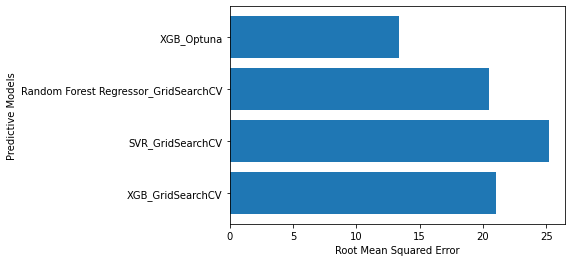

In [329]:
#Plotting the RMSE values for all the 4 approaches
y_values = np.array([rmse_xgb_gridsearchcv, rmse_svr, rmse_rfr, rmse_xgb_optuna])
x_values = np.array(['XGB_GridSearchCV','SVR_GridSearchCV','Random Forest Regressor_GridSearchCV','XGB_Optuna'])
plt.ylabel("Predictive Models")
plt.xlabel("Root Mean Squared Error")
plt.barh(x_values, y_values)
plt.show()